### Author: Kyle Tranfaglia ###
### Course: DSCI 470 ###
### Assignment: The Project ###
### Last Updated: 11/04/24 ###

## Questions: ## 
### How do opening choices and event types differ across Elo ratings, and are certain openings more likely in specific events or Elo ranges? ###
### How do rating differences and player Elo impact game outcomes and the predictability of the game results? ### 
### Which game features, along with Elo difference, helps to predict the game result, and how can these insights inform match-making criteria? ###

## Prepare for Analysis: Import Libraries and Read in Data

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay


# Read in data set and strip beginning spaces from the 'Event' column
df_chess = pd.read_csv("Data/Big_chess_data.csv", converters= {'Event': lambda x: x.strip() if isinstance(x, str) else x})


## Utility Functions ##

In [2]:
# Set up the plotting style
sns.set_theme(style='whitegrid')


# Function to plot bar charts
def plot_frequencies(counts, title, xlabel, ylabel):
    # Handle frequencies with too many categories to appropriately disaplay (n > 50)
    top_n = 50
    counts = counts.nlargest(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, legend=False, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.show()


# Extract the first word of a column entry
def extract_first_word(entry):
    return entry.split()[0]


# Extract the first two words of a column entry
def extract_first_two_words(entry):
    words = entry.replace(":", "").replace(",", "").split()  # Remove colons and commas, then split the string
    return ' '.join(words[:2]) if len(words) > 1 else words[0]


# Assign a player strength classification to an Elo
def classify_elo(elo):
    if elo <= 1200:
        return 'Beginner'
    elif elo <= 1800:
        return 'Intermediate'
    elif elo <= 2000:
        return 'Advanced'
    elif elo <= 2200:
        return 'Expert'
    else:
        return 'Master'

## Explore the Data ##

           WhiteElo      BlackElo  WhiteRatingDiff  BlackRatingDiff
count  6.256184e+06  6.256184e+06     6.251516e+06     6.251516e+06
mean   1.741945e+03  1.740390e+03     5.802621e-01    -3.676732e-01
std    2.657171e+02  2.668938e+02     2.285186e+01     2.182012e+01
min    7.370000e+02  7.280000e+02    -5.950000e+02    -6.530000e+02
25%    1.559000e+03  1.557000e+03    -9.000000e+00    -1.000000e+01
50%    1.740000e+03  1.739000e+03     1.000000e+00    -1.000000e+00
75%    1.919000e+03  1.919000e+03     1.000000e+01     9.000000e+00
max    3.110000e+03  3.108000e+03     6.730000e+02     6.640000e+02

               Event            White       Black Result     UTCDate   UTCTime  \
0         Classical          eisaaaa    HAMID449    1-0  2016.06.30  22:00:01   
1             Blitz           go4jas  Sergei1973    0-1  2016.06.30  22:00:01   
2  Blitz tournament  Evangelistaizac      kafune    1-0  2016.06.30  22:00:02   
3    Correspondence           Jvayne    Wsjvayne    1-0  2016.

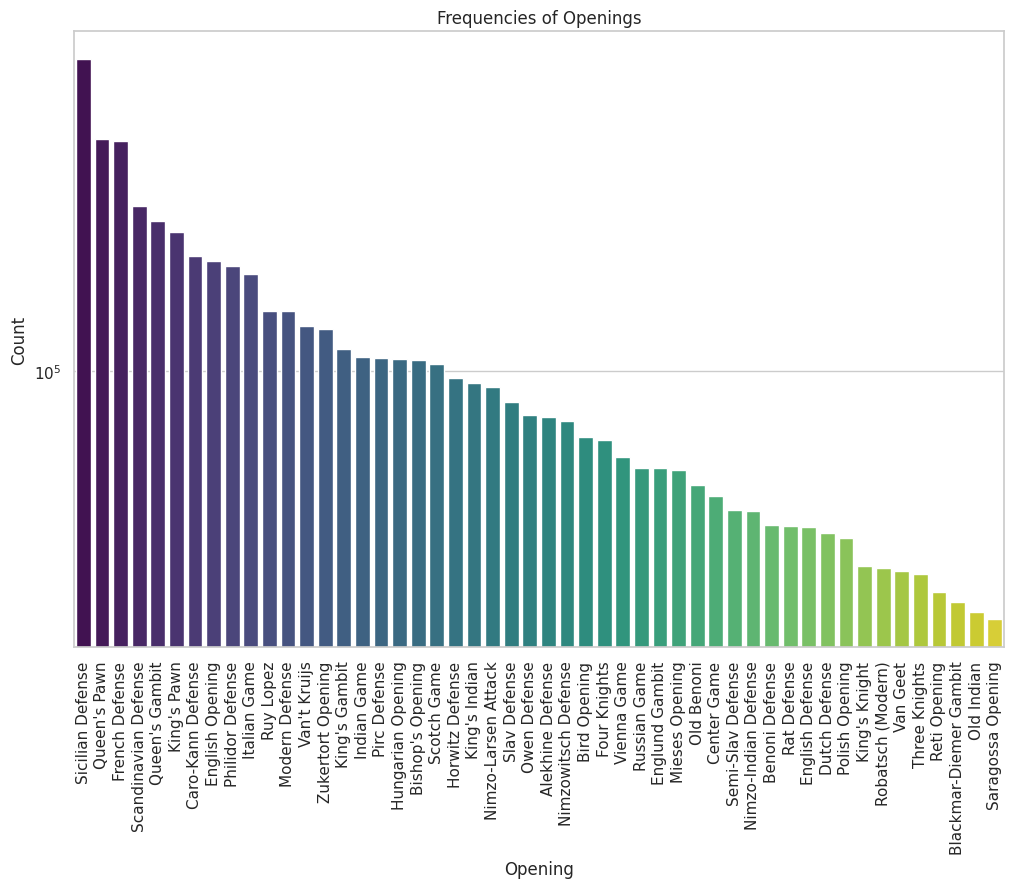


Frequency of ECO
A00    423144
A40    290613
C00    289673
B01    286686
D00    229168
        ...  
E03         5
E55         5
B69         1
C76         1
E96         1
Name: count, Length: 493, dtype: int64


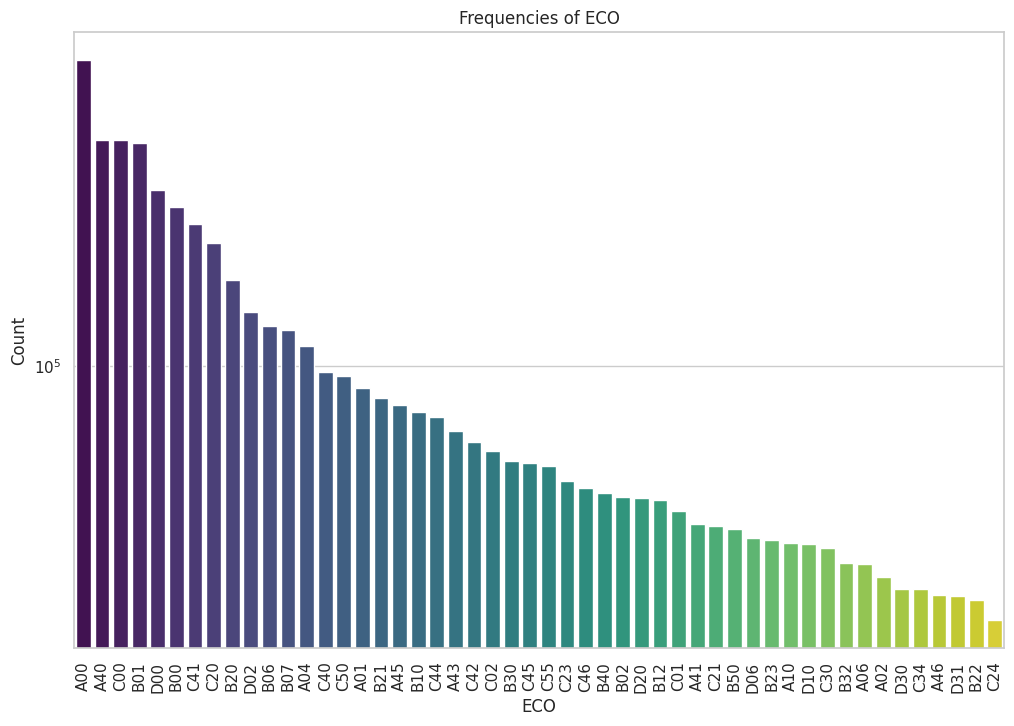


Frequency of TimeControl
300+0      1075140
180+0       948615
60+0        912781
600+0       580351
30+0        307065
            ...   
7200+90          1
9000+60          1
540+17           1
120+150          1
720+25           1
Name: count, Length: 841, dtype: int64


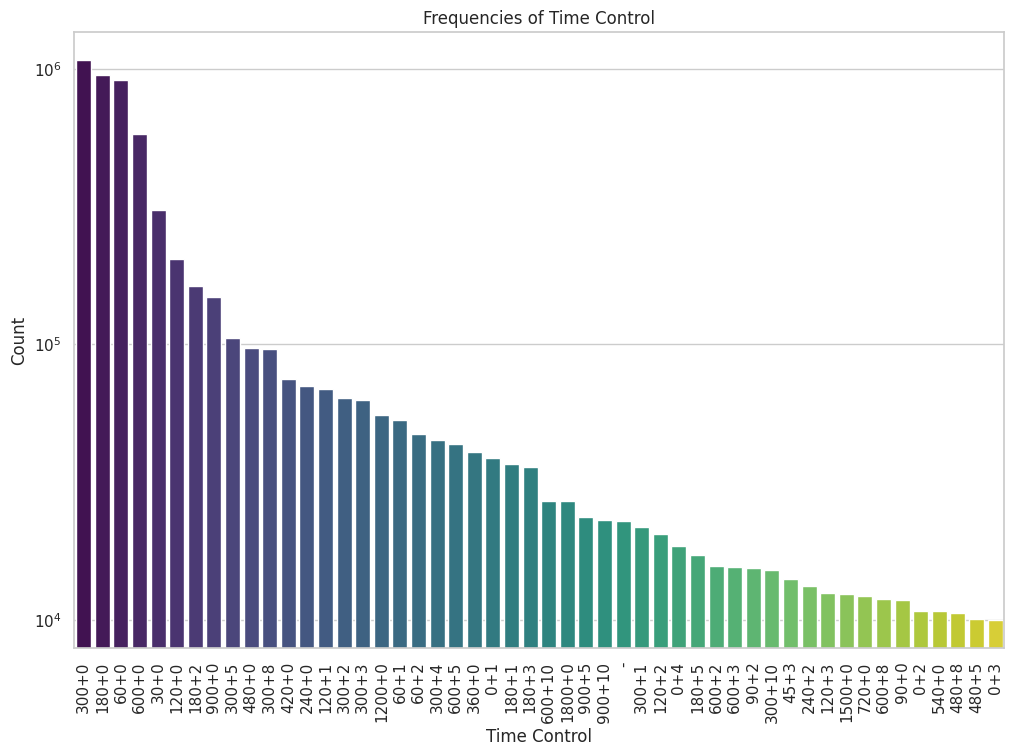


Frequency of Event
Blitz                   2339574
Classical               1510811
Bullet                  1198185
Bullet tournament        546777
Blitz tournament         472262
Classical tournament     165635
Correspondence            22940
Name: count, dtype: int64


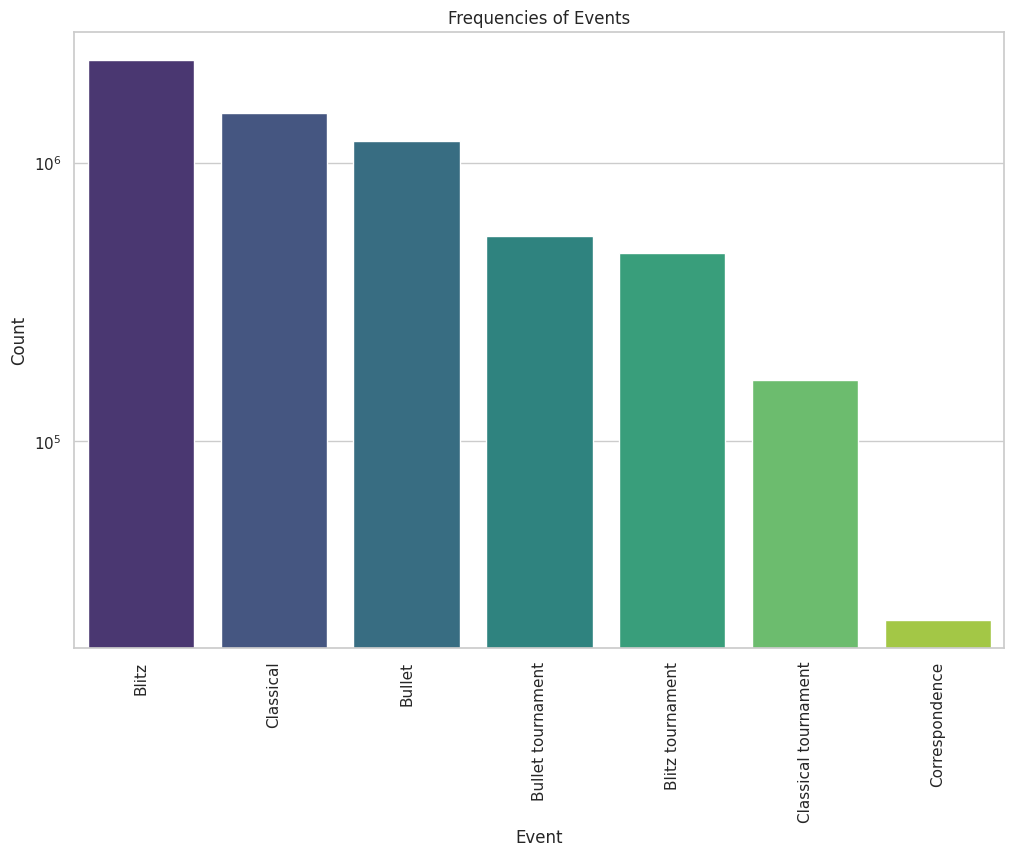


Frequency of Termination
Normal              4230089
Time forfeit        2011336
Abandoned             14630
Rules infraction        128
Unterminated              1
Name: count, dtype: int64


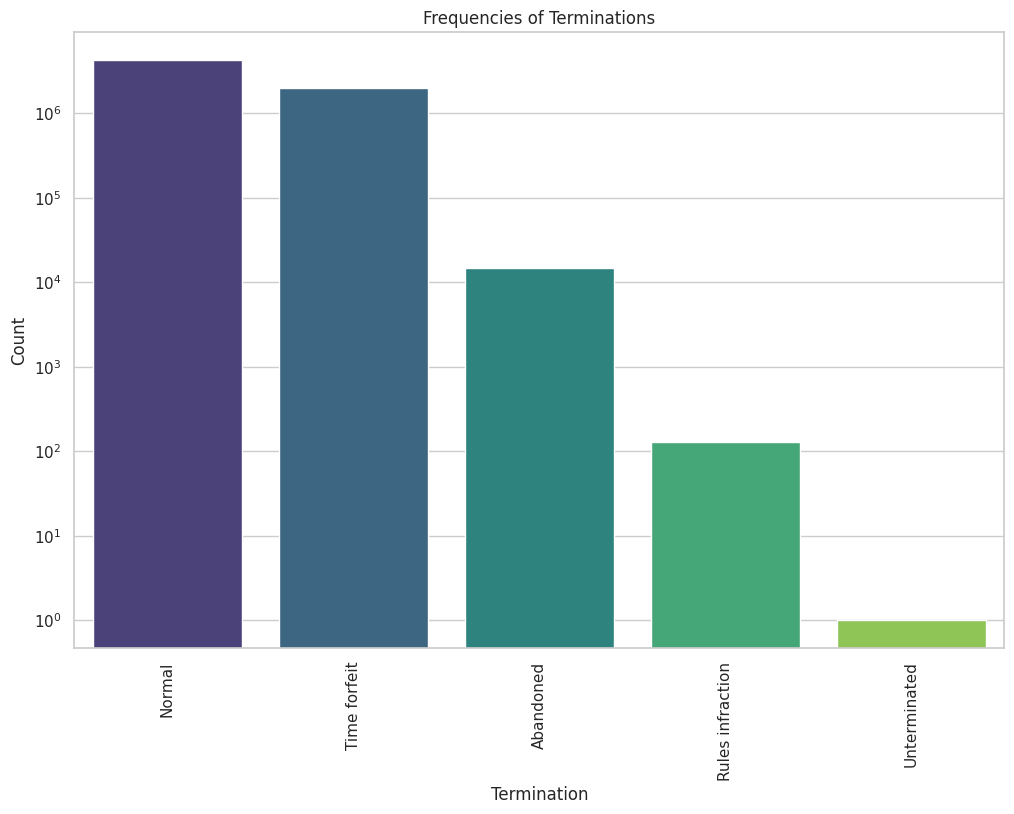


Frequency of EloGroup
Intermediate    3686960
Advanced        1590945
Expert           692667
Master           216238
Beginner          69374
Name: count, dtype: int64


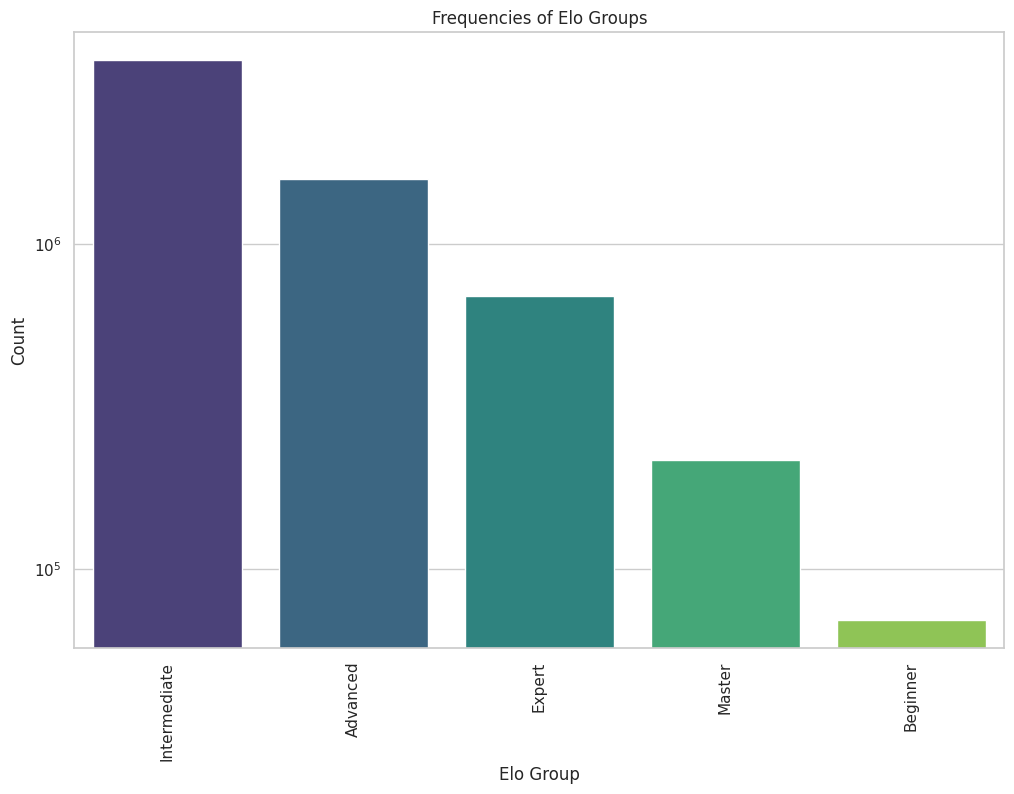

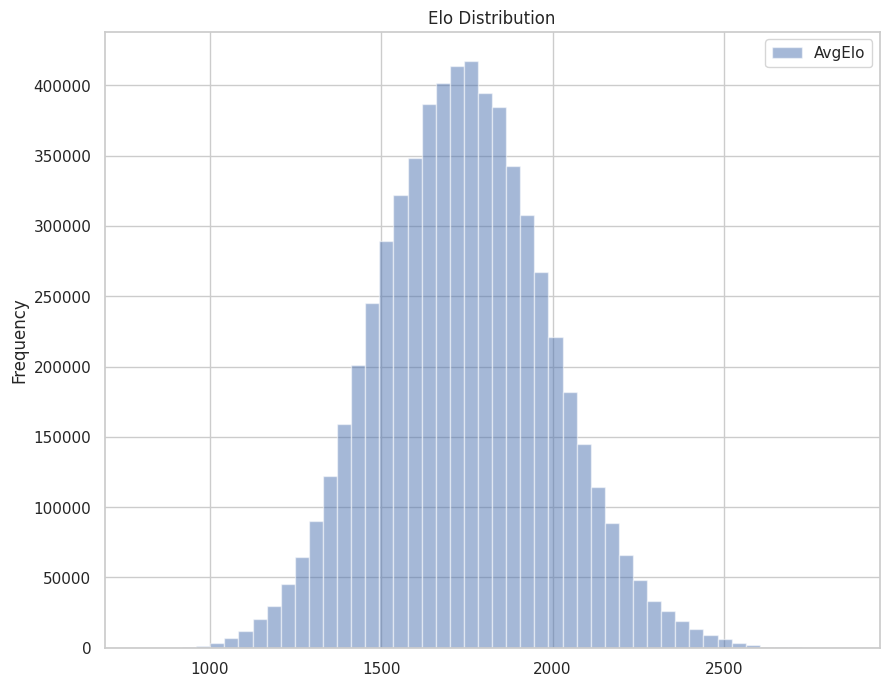

<Figure size 1000x800 with 0 Axes>

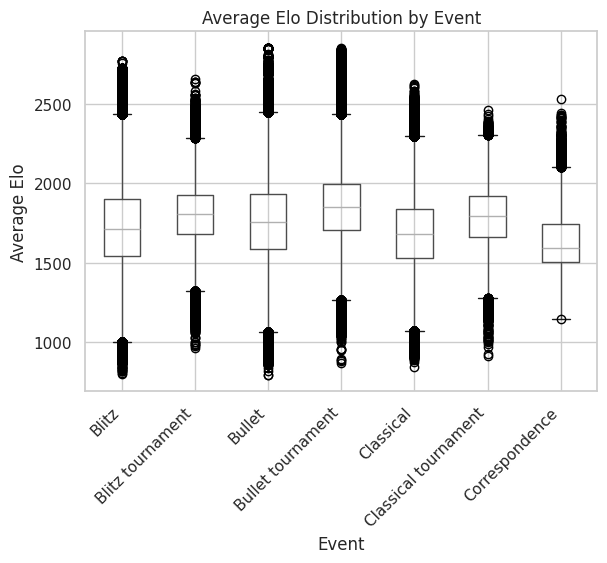

In [3]:
'''Display basic information on the data'''
# Display some data, statistics, and summary info
print(df_chess.describe())
print("\n", df_chess.head())

'''Add five new columns to the dataset for analysis'''
# Create a new column for the Elo group of each player
df_chess['WhiteEloGroup'] = df_chess['WhiteElo'].apply(classify_elo)
df_chess['BlackEloGroup'] = df_chess['BlackElo'].apply(classify_elo)

# Calculate average Elo and Elo group based on the average Elo for each game and add to the DataFrame
df_chess['AvgElo'] = df_chess[['WhiteElo', 'BlackElo']].mean(axis=1)
df_chess['EloGroup'] = df_chess['AvgElo'].apply(classify_elo)

# Create a new column with generalized openings (group all opening variations)
df_chess['generalized_Opening'] = df_chess['Opening'].apply(extract_first_two_words)

'''Get the mode for each feature, display the values in descending order, and represent it with a bar plot figure'''
# Get and display data fequencies for some features
opening_counts = df_chess['generalized_Opening'].value_counts().sort_values(ascending=False)
print("\nFrequency of", opening_counts)
plot_frequencies(opening_counts, 'Frequencies of Openings', 'Opening', 'Count')

ECO_counts = df_chess['ECO'].value_counts().sort_values(ascending=False)
print("\nFrequency of", ECO_counts)
plot_frequencies(ECO_counts, 'Frequencies of ECO', 'ECO', 'Count')

time_control_counts = df_chess['TimeControl'].value_counts().sort_values(ascending=False)
print("\nFrequency of", time_control_counts)
plot_frequencies(time_control_counts, 'Frequencies of Time Control', 'Time Control', 'Count')

event_counts = df_chess['Event'].value_counts().sort_values(ascending=False)
print("\nFrequency of", event_counts)
plot_frequencies(event_counts, 'Frequencies of Events', 'Event', 'Count')

termination_counts = df_chess['Termination'].value_counts().sort_values(ascending=False)
print("\nFrequency of", termination_counts)
plot_frequencies(termination_counts, 'Frequencies of Terminations', 'Termination', 'Count')

elo_group_counts = df_chess['EloGroup'].value_counts().sort_values(ascending=False)
print("\nFrequency of", elo_group_counts)
plot_frequencies(elo_group_counts, 'Frequencies of Elo Groups', 'Elo Group', 'Count')

'''Plot a historgram and boxplots for Elo distributions by event'''
df_chess[['AvgElo']].plot(kind='hist', bins=50, alpha=0.5, title='Elo Distribution', figsize=(10, 8))

# Create the boxplot for Average Elo ratings by Event
plt.figure(figsize=(10, 8))
df_chess.boxplot(column='AvgElo', by='Event')

plt.title('Average Elo Distribution by Event')
plt.xlabel('Event')
plt.ylabel('Average Elo')

plt.xticks(rotation=45, ha='right')
plt.suptitle('')  # Remove the automatic generated title
plt.show()

## Explore the Question: How do opening choices and event types differ across Elo ratings, and are certain openings more likely in specific events or Elo ranges? ##

Elo by Chess Opening                               WhiteElo     BlackElo       AvgElo      EloGroup
generalized_Opening                                                           
Alekhine Defense           1778.085303  1800.843348  1789.464325  Intermediate
Amar Opening               1577.721702  1675.670638  1626.696170  Intermediate
Amazon Attack              1494.263498  1554.662667  1524.463083  Intermediate
Amsterdam Attack           1736.111111  1634.111111  1685.111111  Intermediate
Anderssen Opening          1718.409207  1739.393732  1728.901469  Intermediate
...                                ...          ...          ...           ...
Ware Opening               1678.629814  1732.789986  1705.709900  Intermediate
Yusupov-Rubinstein System  1831.152334  1846.002132  1838.577233      Advanced
Zaire Defense              1627.250000  1524.375000  1575.812500  Intermediate
Zukertort Defense          1680.102041  1633.775510  1656.938776  Intermediate
Zukertort Opening          1808

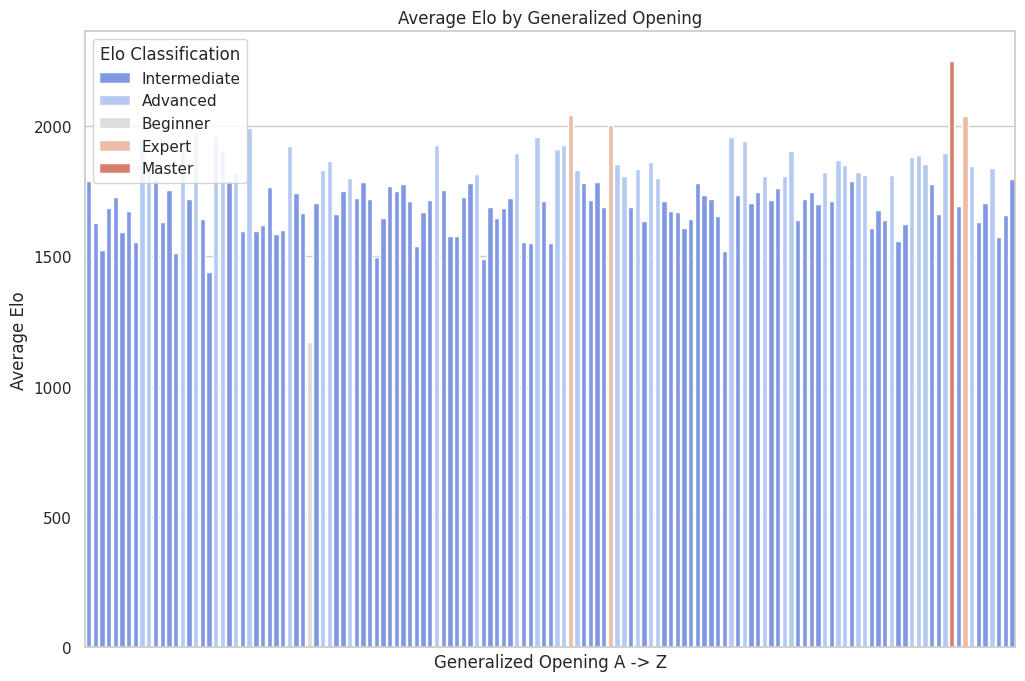


Opeining by Most Frequent Elo Group            generalized_Opening  EloGroup  Count  NormalizedCount
0             Alekhine Defense    Master  10163         0.018334
1                 Amar Opening  Beginner    229         0.000941
2                Amazon Attack  Beginner    404         0.001661
3             Amsterdam Attack  Beginner      1         0.000004
4            Anderssen Opening    Expert   1785         0.001205
..                         ...       ...    ...              ...
134               Ware Opening  Beginner    479         0.001969
135  Yusupov-Rubinstein System    Master    879         0.001586
136              Zaire Defense  Beginner      1         0.000004
137          Zukertort Defense    Expert     15         0.000010
138          Zukertort Opening    Master  22722         0.040990

[139 rows x 4 columns]

Opening by Most Frequent Elo Group

Elo Group: Advanced
    generalized_Opening  NormalizedCount
38      English Defense         0.006899
100         Rat Defe

/tmp/ipykernel_129994/1206475975.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elo_group_counts.groupby('generalized_Opening')


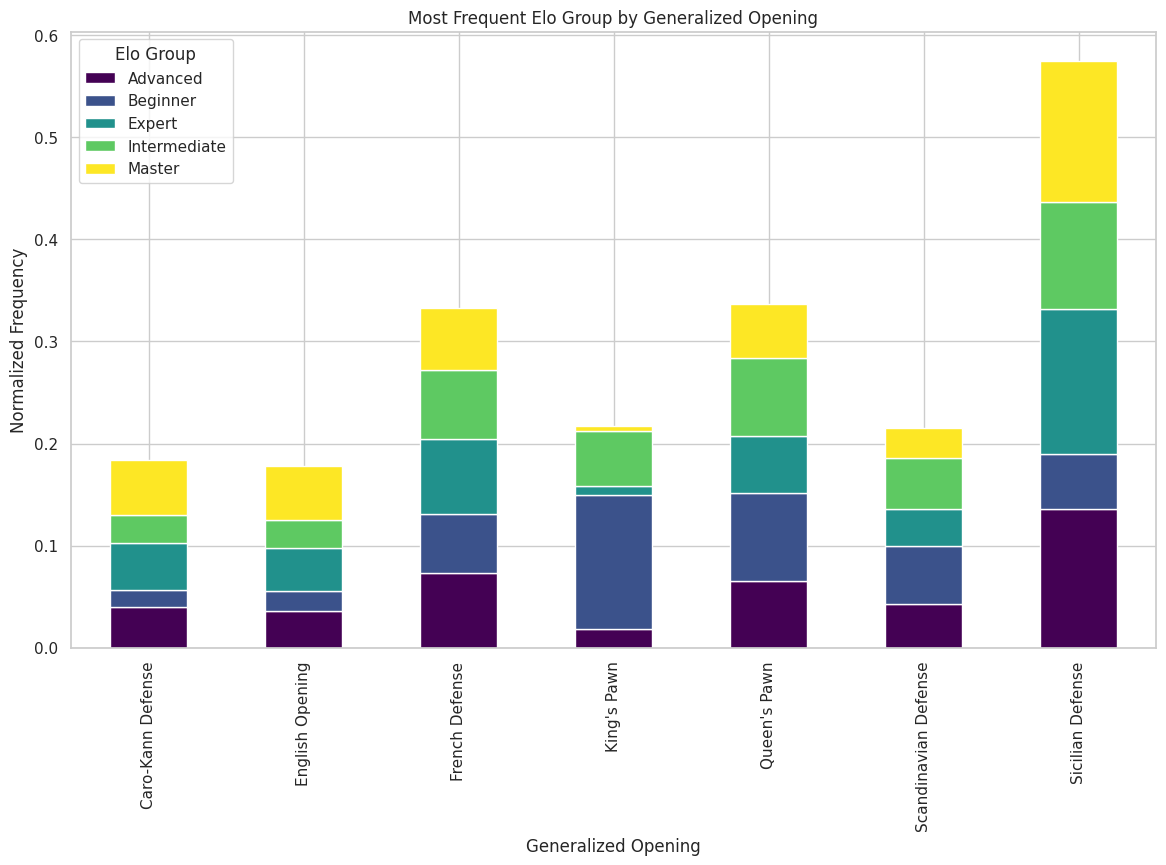


Top Openings by Elo Group         EloGroup   generalized_Opening  Frequency Percentage
0       Advanced      Sicilian Defense     219305     13.78%
1       Advanced        French Defense     117866      7.41%
2       Advanced          Queen's Pawn     101488      6.38%
3       Advanced        Queen's Gambit      68119      4.28%
4       Advanced  Scandinavian Defense      65666      4.13%
5       Beginner           King's Pawn      10707     15.43%
6       Beginner          Queen's Pawn       6362      9.17%
7       Beginner  Scandinavian Defense       3938      5.68%
8       Beginner        French Defense       3936      5.67%
9       Beginner          Van't Kruijs       3118      4.49%
10        Expert      Sicilian Defense     100116     14.45%
11        Expert        French Defense      50160      7.24%
12        Expert          Queen's Pawn      37513      5.42%
13        Expert     Caro-Kann Defense      33575      4.85%
14        Expert       English Opening      29464      4.2

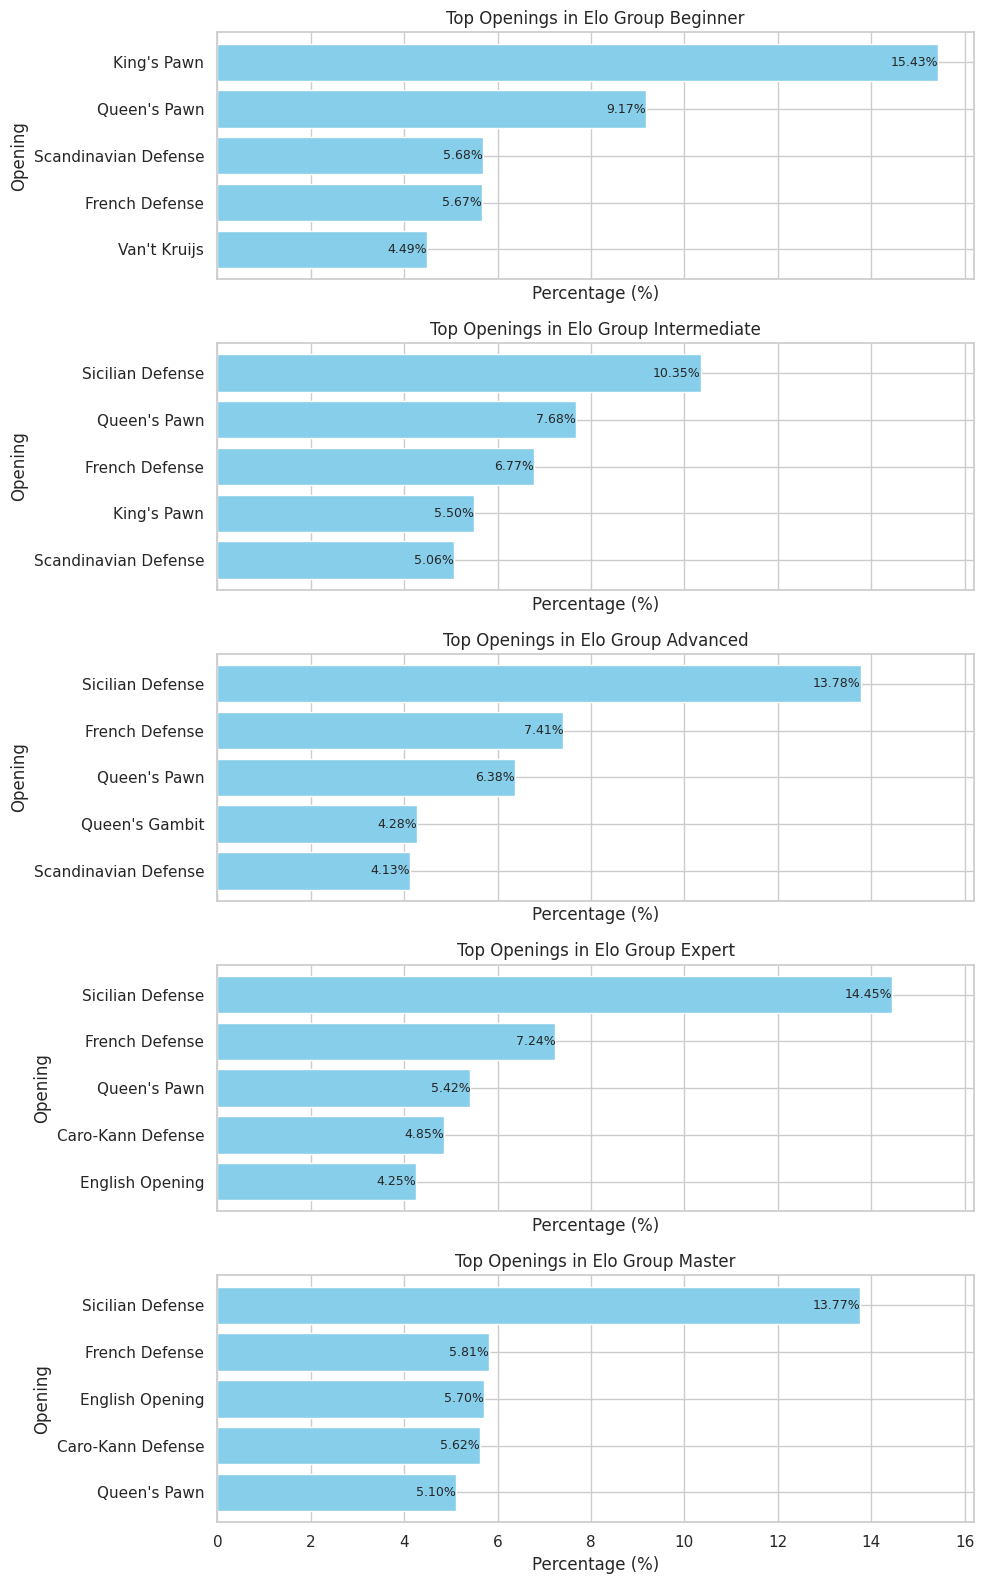


Top Openings by Event                    Event   generalized_Opening  Frequency Percentage
0                  Blitz      Sicilian Defense     309470     13.23%
1                  Blitz        French Defense     173431      7.41%
2                  Blitz          Queen's Pawn     161630      6.91%
3                  Blitz        Queen's Gambit     109193      4.67%
4                  Blitz  Scandinavian Defense     106881      4.57%
5       Blitz tournament      Sicilian Defense      70987     15.03%
6       Blitz tournament        French Defense      35888      7.60%
7       Blitz tournament          Queen's Pawn      32197      6.82%
8       Blitz tournament        Queen's Gambit      20936      4.43%
9       Blitz tournament     Caro-Kann Defense      20339      4.31%
10                Bullet      Sicilian Defense     117758      9.83%
11                Bullet        French Defense      82042      6.85%
12                Bullet          Queen's Pawn      80173      6.69%
13         

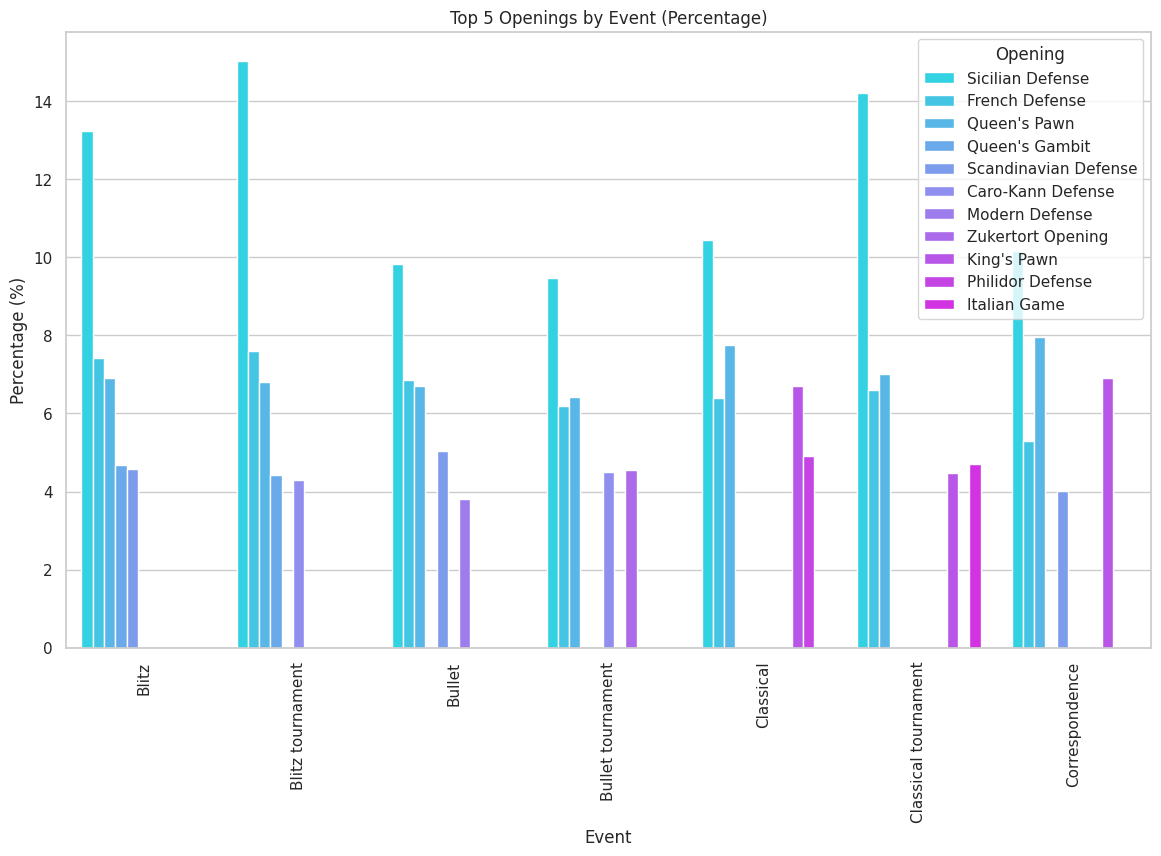


Elo and Elo Group by Event                       Avg White Elo  Avg Black Elo  Avg Combined Elo  \
Event                                                                  
Blitz                   1725.983744    1724.788794       1725.386269   
Blitz tournament        1801.193045    1800.377629       1800.785337   
Bullet                  1763.856282    1762.393901       1763.125091   
Bullet tournament       1853.577378    1853.042162       1853.309770   
Classical               1686.748468    1683.957456       1685.352962   
Classical tournament    1788.284891    1786.507278       1787.396085   
Correspondence          1645.523104    1645.881866       1645.702485   

                     Elo Classification  
Event                                    
Blitz                      Intermediate  
Blitz tournament               Advanced  
Bullet                     Intermediate  
Bullet tournament              Advanced  
Classical                  Intermediate  
Classical tournament       In

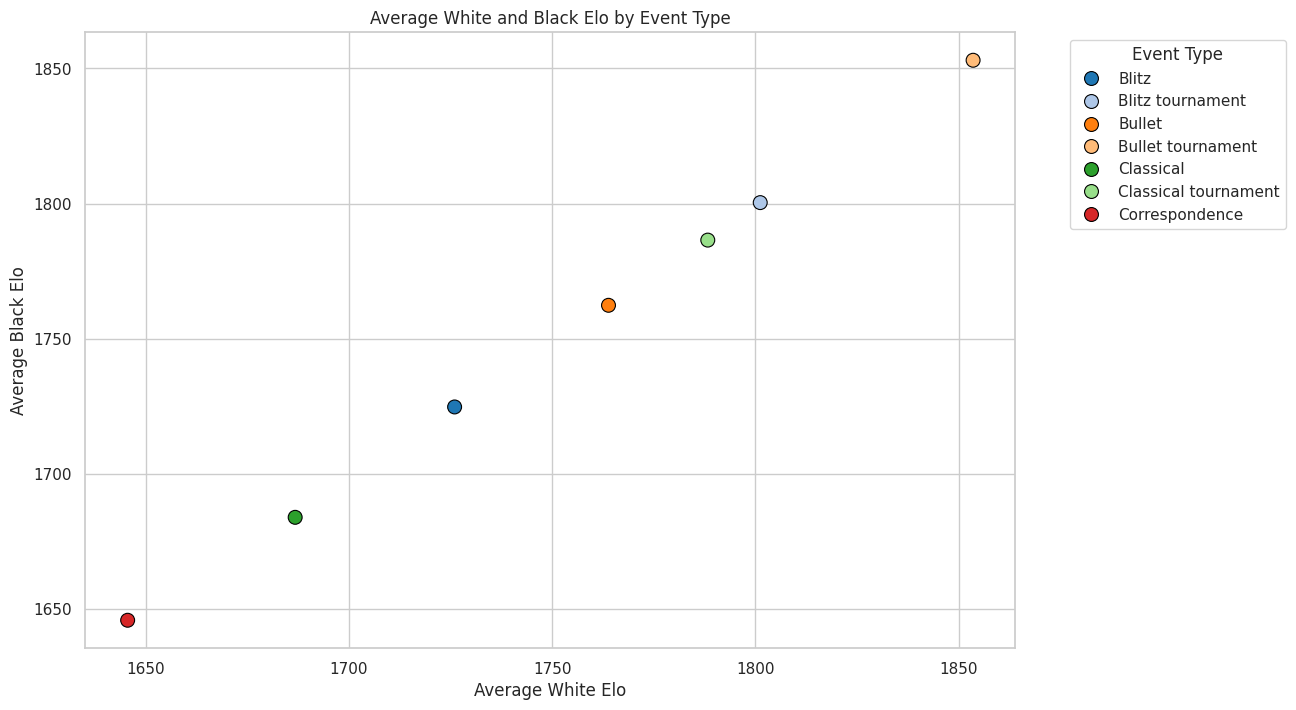


Most Frequent Elo Group by Event                   Event      EloGroup    Count  NormalizedCount
0                 Blitz      Beginner   124540         0.512000
1      Blitz tournament      Advanced   319745         0.103654
2                Bullet        Master   137592         0.248210
3     Bullet tournament        Master   104995         0.189406
4             Classical  Intermediate  1995353         0.279123
5  Classical tournament        Expert    50575         0.034140
6        Correspondence  Intermediate    35000         0.004896


/tmp/ipykernel_129994/1206475975.py:216: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elo_group_counts_by_event.groupby('Event', group_keys=False)


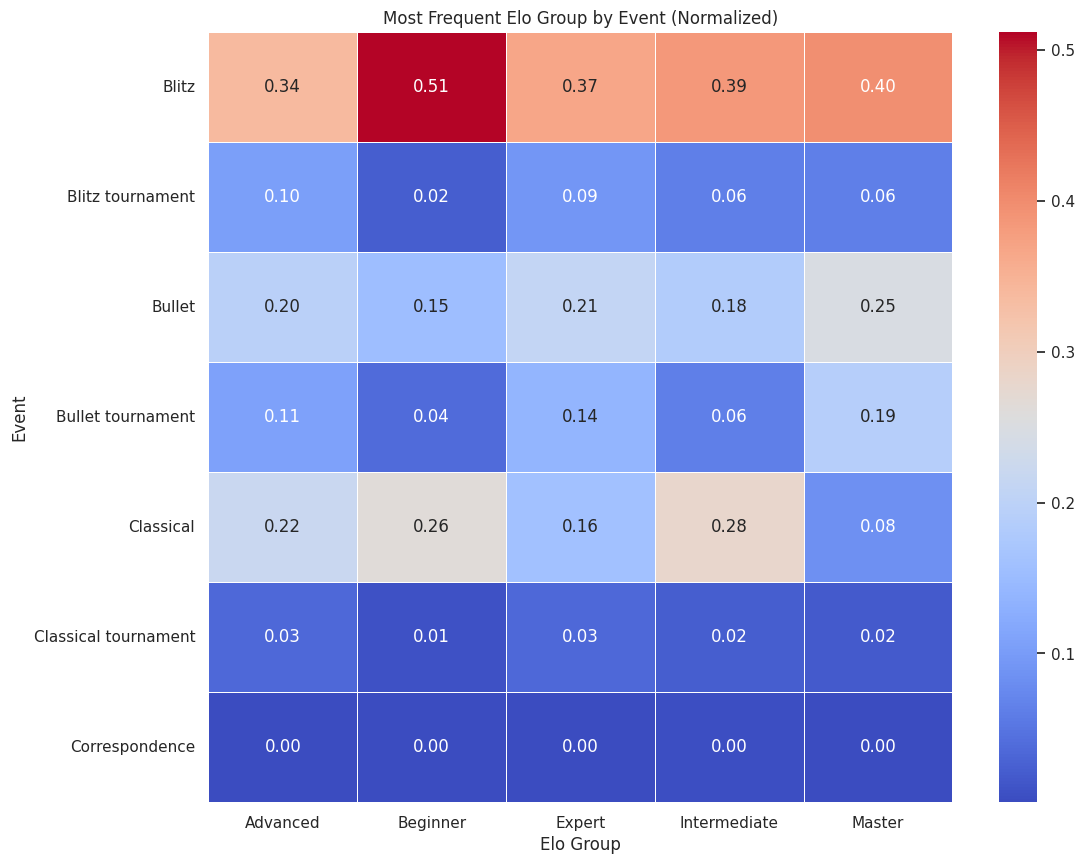

In [4]:
'''Calculate and display the average elo for black, white, and combined with a classification for the elo for each generalized opening'''
# Get the average elo of players that use each opening by grouping 'generalized_Opening' and 'WhiteElo' and 'BlackElo'
avg_opening_elo = df_chess.groupby('generalized_Opening')[['WhiteElo', 'BlackElo']].mean()

# Create a new column for combined average Elo & categorize each opening based on its average Elo
avg_opening_elo['AvgElo'] = avg_opening_elo.mean(axis=1)
avg_opening_elo['EloGroup'] = avg_opening_elo['AvgElo'].apply(classify_elo)
print("Elo by Chess Opening", avg_opening_elo)

# Group the openings by the average Elo Group and display them
print("\nOpening by Average Elo Group")
for group, openings in avg_opening_elo.groupby('EloGroup'):
    print(f"\nElo Group: {group}")
    print(openings[['AvgElo']].sort_values(by='AvgElo', ascending=False))

# Bar plot for average Elo by opening with classification color
plt.figure(figsize=(12, 8))
sns.barplot(
    x=avg_opening_elo.index,
    y=avg_opening_elo['AvgElo'],
    hue=avg_opening_elo['EloGroup'],
    palette="coolwarm"
)
plt.xticks([])  # Remove x-axis labels
plt.title('Average Elo by Generalized Opening')
plt.xlabel('Generalized Opening A -> Z')
plt.ylabel('Average Elo')
plt.legend(title='Elo Classification')
plt.show()

'''Use the elo group frequencies for each opening and the total number of players in each elo group to normalize the mode of each 
opening within an elo group and display the most frequent elo group for each generalized opening'''

# Combine White and Black Elo groups into a single DataFrame for counting
elo_groups_combined = pd.concat([
    df_chess[['generalized_Opening', 'WhiteEloGroup']].rename(columns={'WhiteEloGroup': 'EloGroup'}),
    df_chess[['generalized_Opening', 'BlackEloGroup']].rename(columns={'BlackEloGroup': 'EloGroup'})])

# Count the frequency of each Elo group for each opening & count the total number of players in each Elo group
elo_group_counts = elo_groups_combined.groupby(['generalized_Opening', 'EloGroup']).size().reset_index(name='Count')
total_players_by_elo_group = elo_group_counts.groupby('EloGroup')['Count'].sum()

# Normalize the frequency of openings within each Elo group by dividing by the total number of players in that group
# This is significant as the elo groups are inbalanced which would lead to bias
elo_group_counts['NormalizedCount'] = elo_group_counts.apply(
    lambda row: row['Count'] / total_players_by_elo_group[row['EloGroup']], axis=1)

# For each opening, find the Elo group with the highest frequency
most_frequent_elo_group = (
    elo_group_counts.groupby('generalized_Opening')
    .apply(lambda x: x.loc[x['NormalizedCount'].idxmax()])  # Get the row with the highest count for each opening
    .reset_index(drop=True))
print("\nOpeining by Most Frequent Elo Group", most_frequent_elo_group)

# Iterate through the groups and display the openings in each Elo Group
print("\nOpening by Most Frequent Elo Group")
for group, openings in most_frequent_elo_group.groupby('EloGroup'):
    print(f"\nElo Group: {group}")
    print(openings[['generalized_Opening', 'NormalizedCount']].sort_values(by='NormalizedCount', ascending=False))

# Pivot for stacked bar chart of Elo group frequencies by opening
elo_group_pivot = elo_group_counts.pivot(index='generalized_Opening', columns='EloGroup', values='NormalizedCount')
elo_group_pivot = elo_group_pivot.fillna(0)  # Fill NaN with zero for missing counts
elo_group_pivot = elo_group_pivot[elo_group_pivot.apply(lambda row: row.max() > 0.05, axis=1)]  # Filter to show only elements with frequency > 0.05

# Stacked bar chart
elo_group_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Most Frequent Elo Group by Generalized Opening')
plt.xlabel('Generalized Opening')
plt.ylabel('Normalized Frequency')
plt.xticks(rotation=90)
plt.legend(title='Elo Group')
plt.show()

'''Calculate and display the top 5 most frequent openings played for each elo group with a percentage of the total games that the opening was played'''
# Calculate the frequency of each 'generalized_Opening' within each 'EloGroup'
top_openings_by_elo_group = (
    df_chess.groupby('EloGroup')['generalized_Opening']
    .value_counts()
    .groupby(level=0)
    .nlargest(5)
    .reset_index(level=0, drop=True)
).reset_index(name='Frequency')

total_games_by_elo_group = df_chess['EloGroup'].value_counts()  # Calculate the total games for each Elo group

# Calculate the percentage of total games each opening represents within its Elo group
top_openings_by_elo_group['Percentage'] = top_openings_by_elo_group.apply(
    lambda row: f"{(row['Frequency'] / total_games_by_elo_group[row['EloGroup']]) * 100:.2f}%", axis=1)
print("\nTop Openings by Elo Group", top_openings_by_elo_group)

# Convert the 'Percentage' column to numeric values, removing the '%' symbol
top_openings_by_elo_group['PercentageNumeric'] = top_openings_by_elo_group['Percentage'].str.rstrip('%').astype(float)

# Define the desired order of Elo groups
elo_group_order = ['Beginner', 'Intermediate', 'Advanced', 'Expert', 'Master']

# Calculate the percentage of total games each opening represents within its Elo group
top_openings_by_elo_group['Percentage'] = top_openings_by_elo_group.apply(
    lambda row: f"{(row['Frequency'] / total_games_by_elo_group[row['EloGroup']]) * 100:.2f}%", axis=1)

# Convert the 'Percentage' column to numeric values, removing the '%' symbol
top_openings_by_elo_group['PercentageNumeric'] = top_openings_by_elo_group['Percentage'].str.rstrip('%').astype(float)

# Reorder the DataFrame based on the specified Elo group order
top_openings_by_elo_group['EloGroup'] = pd.Categorical(
    top_openings_by_elo_group['EloGroup'], 
    categories=elo_group_order, 
    ordered=True
)
top_openings_by_elo_group = top_openings_by_elo_group.sort_values('EloGroup')

# Horizontal bar charts for top 5 openings per Elo group using percentage
fig, axes = plt.subplots(nrows=len(elo_group_order), figsize=(10, 16), sharex=True)

for i, elo_group in enumerate(elo_group_order):
    subset = top_openings_by_elo_group[top_openings_by_elo_group['EloGroup'] == elo_group]
    subset = subset.sort_values('PercentageNumeric', ascending=True)  # Sort to have largest on top
    axes[i].barh(subset['generalized_Opening'], subset['PercentageNumeric'], color='skyblue')
    axes[i].set_title(f"Top Openings in Elo Group {elo_group}")
    axes[i].set_xlabel("Percentage (%)")
    axes[i].set_ylabel("Opening")
    for index, value in enumerate(subset['Percentage']):
        axes[i].text(subset['PercentageNumeric'].iloc[index], index, value, ha='right', va='center', fontsize=9)

plt.tight_layout()
plt.show()

'''Calculate and display the top 5 most frequent openings played for each event with a percentage of the total games that the opening was played'''
# Group 'Event' and frequencies of each 'generalized_Opening' within each event, then get the top 5 most frequent openings
top_openings_by_event = (
    df_chess.groupby('Event')['generalized_Opening']
    .value_counts()
    .groupby(level=0)
    .nlargest(5)
    .reset_index(level=0, drop=True)
).reset_index(name='Frequency')

total_games_by_event = df_chess['Event'].value_counts()  # Get the total amount of games played for each event 

# Calculate the percentage of the total games that an opening was played for each event, and create a formatted column 
top_openings_by_event['Percentage'] = top_openings_by_event.apply(
    lambda row: f"{(row['Frequency'] / total_games_by_event[row['Event']]) * 100:.2f}%", axis=1)
print("\nTop Openings by Event", top_openings_by_event)

# Calculate the percentage for each opening within each event
top_openings_by_event['Percentage'] = top_openings_by_event.apply(
    lambda row: (row['Frequency'] / total_games_by_event[row['Event']]) * 100, axis=1
)

# Plot the grouped bar chart with percentages
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(
    x='Event', 
    y='Percentage', 
    hue='generalized_Opening', 
    data=top_openings_by_event,
    palette='cool',
    dodge=True
)
plt.xticks(rotation=90)
plt.title('Top 5 Openings by Event (Percentage)')
plt.xlabel('Event')
plt.ylabel('Percentage (%)')
plt.legend(title='Opening')
plt.show()

'''Calculate and display the average black, white, and combined elo for every event type with a classification group for each event'''
# Calculate the average Elo for each event type and create an additional column to represent the combined average Elo and an elo group
avg_elo_by_event = df_chess.groupby('Event')[['WhiteElo', 'BlackElo']].mean()
avg_elo_by_event['AvgElo'] = avg_elo_by_event.mean(axis=1)
avg_elo_by_event = avg_elo_by_event.rename(columns={
    'WhiteElo': 'Avg White Elo',
    'BlackElo': 'Avg Black Elo',
    'AvgElo': 'Avg Combined Elo'})
avg_elo_by_event['Elo Classification'] = avg_elo_by_event['Avg Combined Elo'].apply(classify_elo)
print("\nElo and Elo Group by Event", avg_elo_by_event)

# Scatter plot for average Elo by event type with unique colors for each event
plt.figure(figsize=(12, 8))

# Plot each event type with a different color
sns.scatterplot(
    x=avg_elo_by_event['Avg White Elo'],
    y=avg_elo_by_event['Avg Black Elo'],
    hue=avg_elo_by_event.index,  # Use the event type as the hue
    palette='tab20',  # Use a palette with many distinct colors
    s=100,
    edgecolor='black'
)

# Plot formatting
plt.title('Average White and Black Elo by Event Type')
plt.xlabel('Average White Elo')
plt.ylabel('Average Black Elo')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside for clarity
plt.show()

'''Calculate and display the most frequent elo group in each event using normalized counts'''
# Combine White and Black Elo groups into a single DataFrame for frequency calculation
elo_groups_combined = pd.concat([
    df_chess[['Event', 'WhiteEloGroup']].rename(columns={'WhiteEloGroup': 'EloGroup'}),
    df_chess[['Event', 'BlackEloGroup']].rename(columns={'BlackEloGroup': 'EloGroup'})])

# Count the occurrences of each Elo group for each event & calculate the total number of players in each Elo group
elo_group_counts_by_event = elo_groups_combined.groupby(['Event', 'EloGroup']).size().reset_index(name='Count')
total_players_by_elo_group = elo_group_counts_by_event.groupby('EloGroup')['Count'].sum()

# Normalize the frequency of each Elo group within each event
elo_group_counts_by_event['NormalizedCount'] = elo_group_counts_by_event.apply(
    lambda row: row['Count'] / total_players_by_elo_group[row['EloGroup']], axis=1
)

# Find the most frequent Elo group for each event based on normalized counts
most_frequent_elo_group_by_event = (
    elo_group_counts_by_event.groupby('Event', group_keys=False)
    .apply(lambda x: x.loc[x['NormalizedCount'].idxmax()])  # Get the row with the highest normalized count for each event
    .reset_index(drop=True)
)
print("\nMost Frequent Elo Group by Event", most_frequent_elo_group_by_event)

# Pivot for heatmap data
heatmap_data = elo_group_counts_by_event.pivot(index='Event', columns='EloGroup', values='NormalizedCount').fillna(0)

# Heatmap of normalized Elo group frequencies by event
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Most Frequent Elo Group by Event (Normalized)')
plt.xlabel('Elo Group')
plt.ylabel('Event')
plt.show()

## Explore the Question: How do rating differences and player Elo groups impact game outcomes and the predictability of the game results? ##


White win Probability by Elo Difference
 Result           0-1       1-0   1/2-1/2
EloDiffBin                              
0 to 10     0.452940  0.502163  0.044632
11 to 20    0.443462  0.511918  0.044361
21 to 30    0.429401  0.524585  0.045800
31 to 40    0.421928  0.533902  0.043978
41 to 50    0.408064  0.548235  0.043414
51 to 60    0.399037  0.558075  0.042646
61 to 70    0.384366  0.572510  0.042939
71 to 80    0.375256  0.581759  0.042722
81 to 90    0.362148  0.595062  0.042606
91 to 100   0.352776  0.605001  0.042019
100 to 150  0.321389  0.638609  0.039772
151 to 200  0.272213  0.691019  0.036597
201 to 250  0.228453  0.738729  0.032586
251 to 300  0.189372  0.782298  0.028153
301 to 350  0.157973  0.816402  0.025509
351 to 400  0.129521  0.849030  0.021264
401 to 450  0.109230  0.872325  0.018296
451 to 500  0.090372  0.894399  0.014996
500+        0.058354  0.931039  0.010447


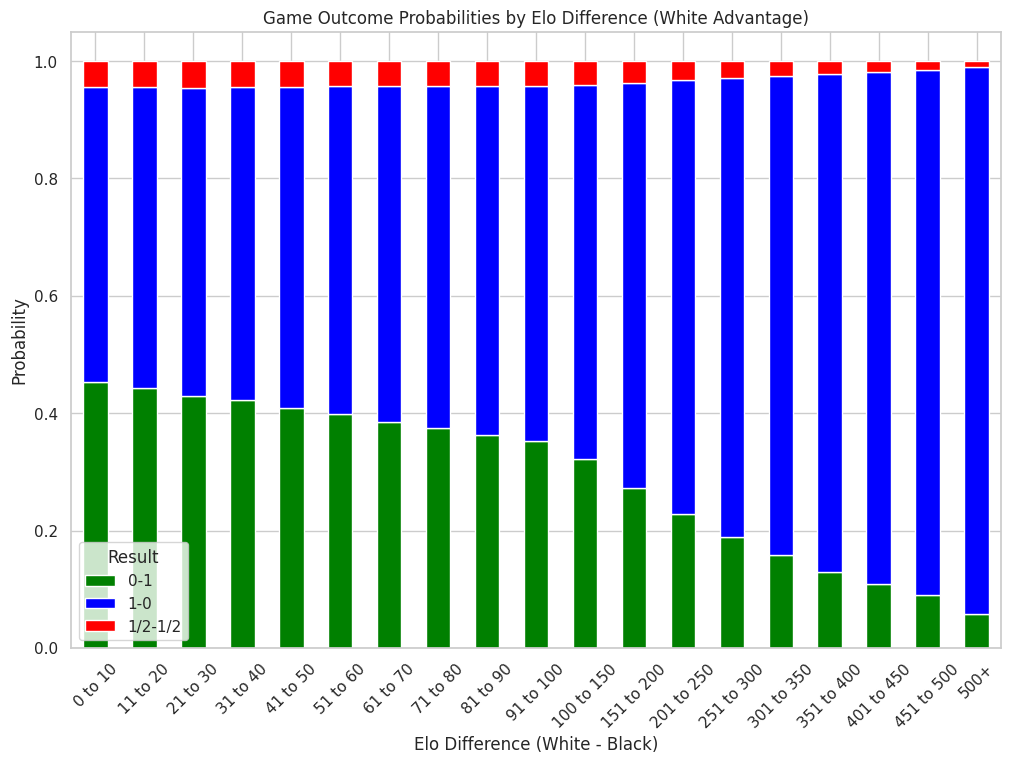


White win Probability for each Elo Group by Elo Difference
 Result                         0-1       1-0   1/2-1/2
WhiteEloGroup EloDiffBin                              
Advanced      0 to 10     0.450788  0.501097  0.047784
              11 to 20    0.440726  0.511002  0.048062
              21 to 30    0.428476  0.522365  0.048880
              31 to 40    0.420967  0.531933  0.046922
              41 to 50    0.409036  0.545136  0.045436
...                            ...       ...       ...
Master        301 to 350  0.139276  0.827544  0.033098
              351 to 400  0.110953  0.860472  0.028270
              401 to 450  0.097369  0.876682  0.025949
              451 to 500  0.088303  0.894921  0.016623
              500+        0.050335  0.938692  0.010755

[95 rows x 3 columns]


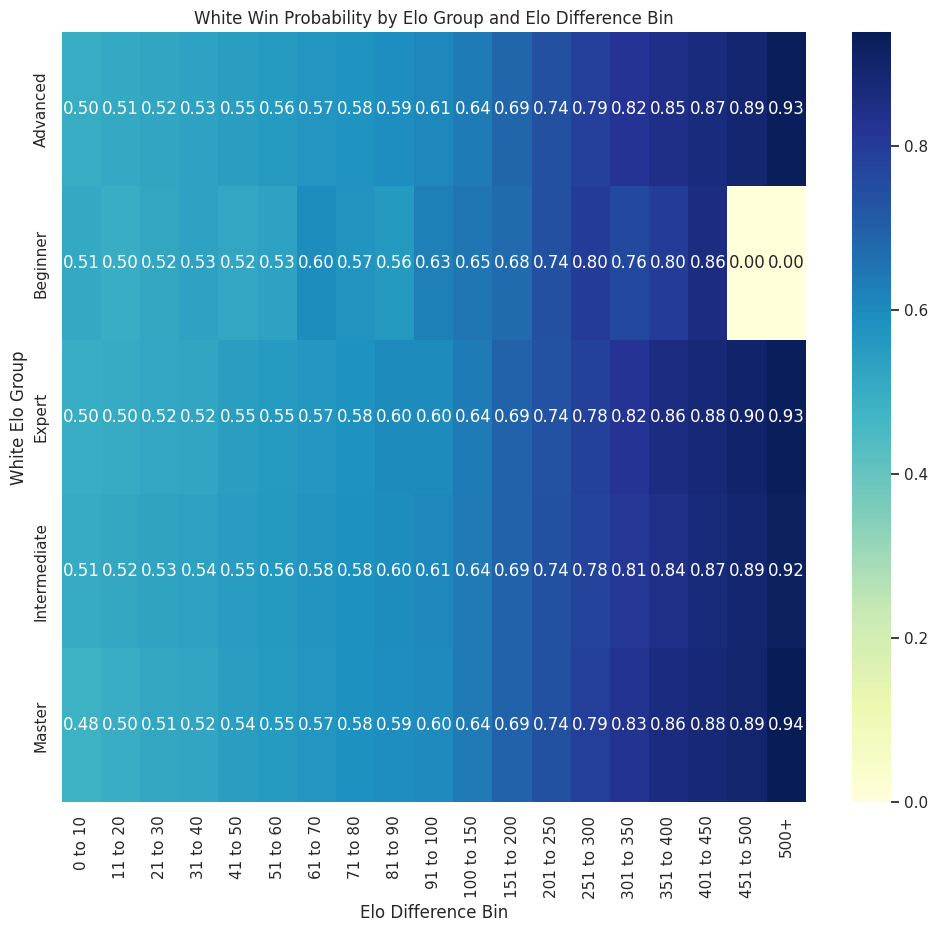


White win ratios for each Elo Group by Elo Difference
 EloDiffBin
0 to 10       0.502163
11 to 20      0.511918
21 to 30      0.524585
31 to 40      0.533902
41 to 50      0.548235
51 to 60      0.558075
61 to 70      0.572510
71 to 80      0.581759
81 to 90      0.595062
91 to 100     0.605001
100 to 150    0.638609
151 to 200    0.691019
201 to 250    0.738729
251 to 300    0.782298
301 to 350    0.816402
351 to 400    0.849030
401 to 450    0.872325
451 to 500    0.894399
500+          0.931039
Name: BinaryResult, dtype: float64


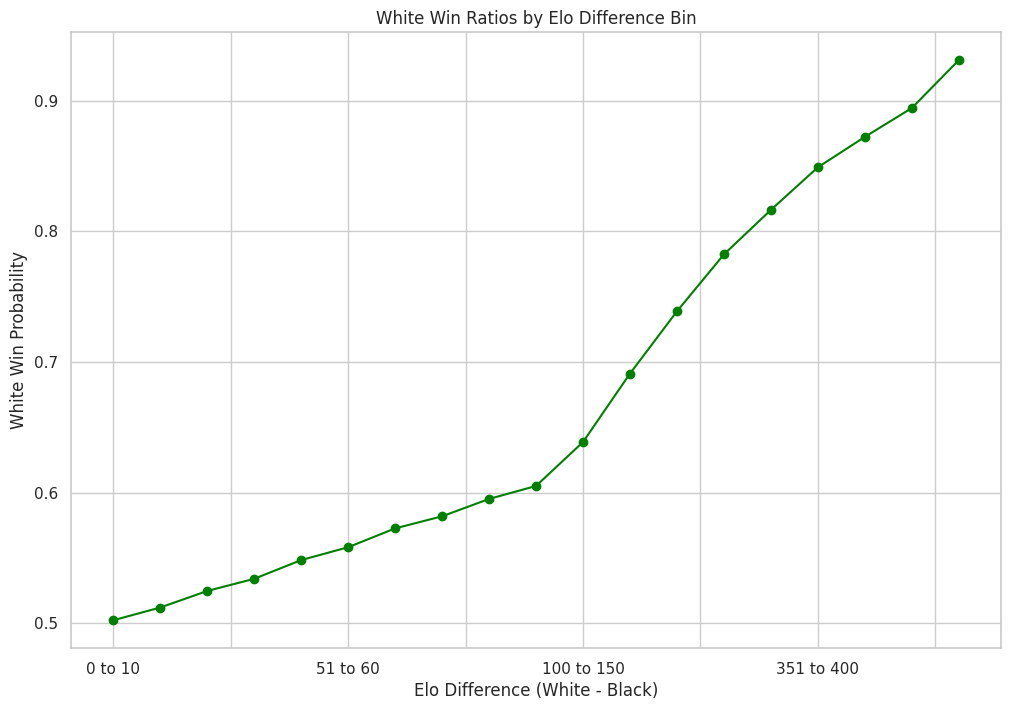

Binary Result Model Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65    313866
           1       0.65      0.64      0.65    311753

    accuracy                           0.65    625619
   macro avg       0.65      0.65      0.65    625619
weighted avg       0.65      0.65      0.65    625619
 Binary Result Model Accuracy: 0.6491826495039313


<Figure size 1200x1000 with 0 Axes>

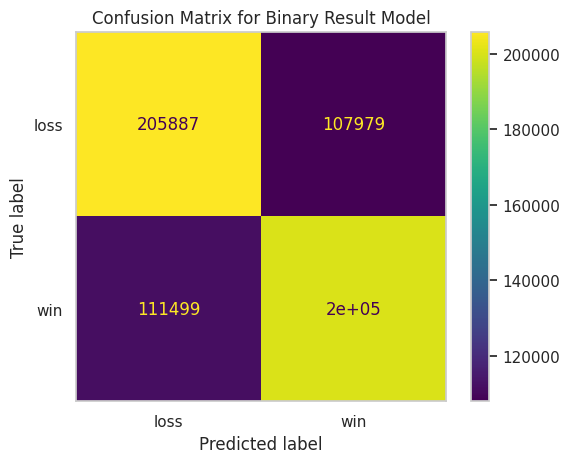

In [5]:
'''Bin the Elo differences and calculate the outcome probabilities within each Elo bin and each Elo Group for each Elo bin'''
# Calculate the Elo difference between White and Black (keeping sign to indicate advantage)
df_chess['EloDifference'] = df_chess['WhiteElo'] - df_chess['BlackElo']

# Define Elo difference bins and labels
elo_diff_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, float('inf')]
elo_diff_labels = ['0 to 10', '11 to 20', '21 to 30', '31 to 40', '41 to 50', '51 to 60', '61 to 70', '71 to 80', '81 to 90', '91 to 100', '100 to 150', '151 to 200', '201 to 250', '251 to 300', '301 to 350', '351 to 400', '401 to 450', '451 to 500', '500+']

# Create a new column for Elo difference bins
df_chess['EloDiffBin'] = pd.cut(df_chess['EloDifference'], bins=elo_diff_bins, labels=elo_diff_labels)

# Calculate outcome probabilities within each EloDiffBin
outcome_probs_by_diff = (
    df_chess.groupby('EloDiffBin', observed=False)['Result']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .drop(columns='*', errors='ignore')
)
print("\nWhite win Probability by Elo Difference\n", outcome_probs_by_diff)

outcome_probs_by_diff.plot(kind='bar', stacked=True, figsize=(12, 8), color=['green', 'blue', 'red'])
plt.title('Game Outcome Probabilities by Elo Difference (White Advantage)')
plt.xlabel('Elo Difference (White - Black)')
plt.ylabel('Probability')
plt.legend(title='Result')
plt.xticks(rotation=45)
plt.show()

# Calculate outcome probabilities for each Elo Group and Elo difference bin
outcome_probs_by_elo_and_diff = (
    df_chess.groupby(['WhiteEloGroup', 'EloDiffBin'], observed=False)['Result']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .drop(columns='*', errors='ignore')
)
print("\nWhite win Probability for each Elo Group by Elo Difference\n", outcome_probs_by_elo_and_diff)

plt.figure(figsize=(12, 10))
sns.heatmap(outcome_probs_by_elo_and_diff.loc[:, '1-0'].unstack(), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('White Win Probability by Elo Group and Elo Difference Bin')
plt.xlabel('Elo Difference Bin')
plt.ylabel('White Elo Group')
plt.show()

'''Calculat and plot white win ratios'''
# Calculate win ratios by EloDiffBin
df_chess['BinaryResult'] = df_chess['Result'].apply(lambda x: 1 if x == '1-0' else 0)
win_ratios = (
    df_chess.groupby('EloDiffBin', observed=False)['BinaryResult']
    .mean()
)
print("\nWhite win ratios for each Elo Group by Elo Difference\n", win_ratios)

win_ratios.plot(kind='line', marker='o', color='green', figsize=(12, 8))
plt.title('White Win Ratios by Elo Difference Bin')
plt.xlabel('Elo Difference (White - Black)')
plt.ylabel('White Win Probability')
plt.grid(True)
plt.show()

'''Train a Logistic Regression model on Elo data to predict game outcomes as binary results'''
# Select features and labels for model input
X = df_chess[['EloDifference', 'WhiteElo', 'BlackElo', 'AvgElo']]
y = df_chess['BinaryResult']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.1, random_state=42)

# Train the logistic regression model
binary_result_model = LogisticRegression()
binary_result_model.fit(X_train, y_train)

# Evaluate the model on the test data
binary_result_predictions = binary_result_model.predict(X_test)
binary_result_accuracy = accuracy_score(y_test, binary_result_predictions)
print("Binary Result Model Classification Report:\n", classification_report(y_test, binary_result_predictions), 
      "Binary Result Model Accuracy:", binary_result_accuracy)

# Binary model confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay.from_predictions(y_test, binary_result_predictions)
plt.title('Confusion Matrix for Binary Result Model')
plt.xticks([0, 1], ["loss", "win"])
plt.yticks([0, 1], ["loss", "win"])
plt.grid(False)
plt.show()



## Explore the Question: Which game features, along with Elo difference, helps to predict the game result, and how can these insights inform match-making criteria? ##

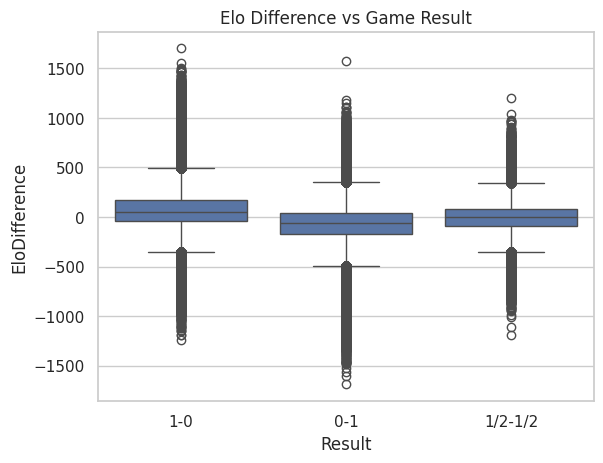

Correlation:
                EloDifference  BinaryResult
EloDifference        1.00000       0.36759
BinaryResult         0.36759       1.00000


/tmp/ipykernel_129994/3527908299.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  logistic_win_probs_by_bin = df_chess.groupby('EloDiffBin')['LogisticWinProbability'].mean()


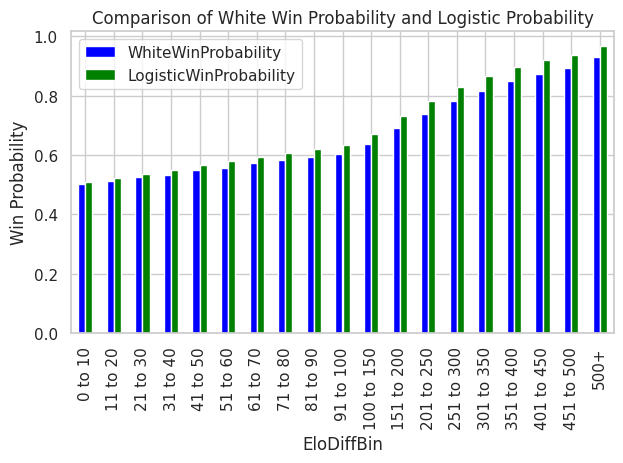

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.59      0.60     10036
           1       0.59      0.60      0.60      9964

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000

Cross-Validation Accuracy Scores: [0.59652017 0.59532023 0.59810981]
Average Accuracy: 0.5967
Accuracy Score:  0.6008333333333333


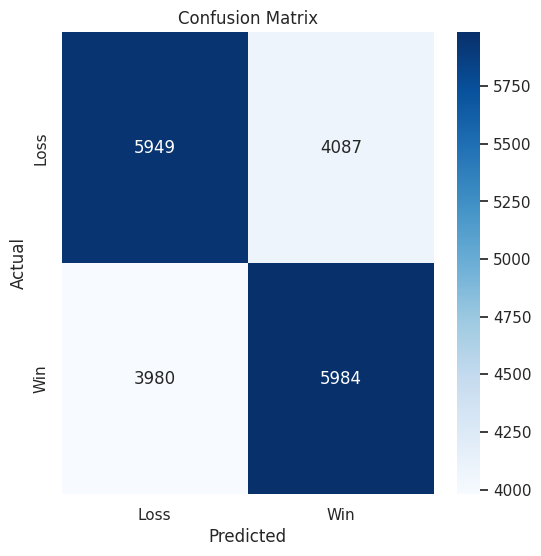


Feature Importances:
                                 Feature  Importance
0                         EloDifference    0.443253
1                   WhiteWinProbability    0.104554
2                Event_Blitz tournament    0.011048
385    generalized_Opening_Queen's Pawn    0.010456
337  generalized_Opening_French Defense    0.009868
..                                  ...         ...
202                   TimeControl_540+7    0.000000
89                   TimeControl_1800+4    0.000000
254                  TimeControl_7200+0    0.000000
32                   TimeControl_1140+8    0.000000
94                  TimeControl_2100+12    0.000000

[419 rows x 2 columns]


In [7]:
'''Plot the relation between game results and elo difference and find the correlation between game results and elo difference'''
# Visualize Game results in relation to Elo Difference
df_chess_filtered = df_chess[df_chess['Result'] != '*']  # Filter out rows with '*' in the 'Result' column
sns.boxplot(x='Result', y='EloDifference', data=df_chess_filtered)
plt.title('Elo Difference vs Game Result')
plt.show()

# One-hot encode categorical features
df_chess_encoded = pd.get_dummies(df_chess.sample(n=1000000, random_state=42), columns=['Event', 'TimeControl', 'generalized_Opening'], drop_first=True)

# Correlation analysis with encoded data
correlation = df_chess_encoded[['EloDifference', 'BinaryResult']].corr()
print("Correlation:\n", correlation)

'''Use one-hot encoding and further prepare data for model training and testing, then train and test a random forest model, then determine the feature importances'''
# Calculate White win probability by EloDiffBin
white_win_probs_by_diff = (
    df_chess.groupby('EloDiffBin', observed=False)['Result']
    .apply(lambda x: (x == '1-0').mean())
)

# Fill NaN values with 0 if there are EloDiffBins with no White wins and map the data
df_chess['WhiteWinProbability'] = pd.Series(
    df_chess['EloDiffBin'].map(white_win_probs_by_diff), 
    dtype='float'
).fillna(0.5)

# Calculate Logistic Win Probability (for comparison)
df_chess['LogisticWinProbability'] = 1 / (1 + 10 ** (df_chess['EloDifference'] * -1 / 400))

# Calculate Logistic probabilities by EloDiffBin (average)
logistic_win_probs_by_bin = df_chess.groupby('EloDiffBin')['LogisticWinProbability'].mean()

# Comparison DataFrame (WhiteWinProbability vs LogisticWinProbability)
comparison_df = pd.DataFrame({
    'EloDiffBin': logistic_win_probs_by_bin.index,
    'WhiteWinProbability': white_win_probs_by_diff,
    'LogisticWinProbability': logistic_win_probs_by_bin
}).reset_index(drop=True)

# Visualization
comparison_df.plot(x='EloDiffBin', y=['WhiteWinProbability', 'LogisticWinProbability'], kind='bar', color=['blue', 'green'])
plt.title("Comparison of White Win Probability and Logistic Probability")
plt.ylabel("Win Probability")
plt.xlabel("EloDiffBin")
plt.legend(['WhiteWinProbability', 'LogisticWinProbability'])
plt.tight_layout()
plt.show()

# For testing purposes, use a smaller subset of the data
df_chess_small = df_chess.sample(n=20000, random_state=42)  # Use a subset

# One-hot encode categorical features for a smaller dataset
df_chess_encoded = pd.get_dummies(df_chess_small, columns=['Event', 'TimeControl', 'generalized_Opening'], drop_first=True)

# Prepare features and target for Random Forest
X = df_chess_encoded[['EloDifference', 'WhiteWinProbability'] + 
                     [col for col in df_chess_encoded.columns if 
                      col.startswith('Event_') or 
                      col.startswith('TimeControl_') or 
                      col.startswith('generalized_Opening_')]]
y = df_chess_encoded['BinaryResult']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model (use all cores for parallelism)
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

# Perform cross-validation and get predictions and calculate accuracy using cross-validation scores
y_pred = cross_val_predict(model_rf, X, y, cv=3)  # 3-fold cross-validation for speed
cv_scores = cross_val_score(model_rf, X, y, cv=3, scoring='accuracy')
print("Classification Report:\n", classification_report(y, y_pred))
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Average Accuracy: {cv_scores.mean():.4f}")
print("Accuracy Score: ", accuracy_score(y_test, model_rf.predict(X_test)))

# Make and plot confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Get feature importance
feature_importances = model_rf.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
print("\nFeature Importances:\n", feature_importance_df.sort_values(by='Importance', ascending=False))


